In [68]:
# %pip install tensorflow
# %pip install keras

# %pip install --upgrade keras
# %pip install --upgrade keras-cv
# %pip install --upgrade keras-hub
# %pip install --upgrade keras
# %pip install --upgrade typing_extensions

# info http://neuralnetworksanddeeplearning.com/chap1.html


# 0 = sigmoid, 1 = tanh, 2 = relu, 3 = leaky relu, 4 = softmax 
ChooseActivationFunction_ONE = 2 
ChooseActivationFunction_TWO = 0 
ChooseActivationFunction_OUTPUT = 4 

In [69]:
# Importiere TensorFlow (bereits in dieser Zelle importiert, kann aber wiederholt werden)
import tensorflow as tf

# Lade das MNIST-Datenset und teile es in Trainings- und Testdaten auf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Prüfe, ob die Datensätze die erwarteten Formen haben
assert x_train.shape == (60000, 28, 28) # Input 
assert x_test.shape == (10000, 28, 28)  # Input
assert y_train.shape == (60000,)        # Feature/Label
assert y_test.shape == (10000,)         # Feature/Label

# Erstelle ein tf.data.Dataset aus dem Trainingsdatensatz
# Dabei werden die Bilder und Labels als Dictionary abgelegt, um später über die Schlüssel zugreifen zu können
ds = tf.data.Dataset.from_tensor_slices({"image": x_train, "label": y_train})


In [70]:
# Determine activation for hidden layer ONE
if ChooseActivationFunction_ONE == 0:
  activation_one = "sigmoid"
elif ChooseActivationFunction_ONE == 1:
  activation_one = "tanh"
elif ChooseActivationFunction_ONE == 2:
  activation_one = "relu"
elif ChooseActivationFunction_ONE == 3:
  activation_one = "leaky relu"
elif ChooseActivationFunction_ONE == 4:
  activation_one = "softmax"
else:
  activation_one = "sigmoid"

# Determine activation for hidden layer TWO
if ChooseActivationFunction_TWO == 0:
  activation_two = "sigmoid"
elif ChooseActivationFunction_TWO == 1:
  activation_two = "tanh"
elif ChooseActivationFunction_TWO == 2:
  activation_two = "relu"
elif ChooseActivationFunction_TWO == 3:
  activation_two = "leaky relu"
elif ChooseActivationFunction_TWO == 4:
  activation_two = "softmax"
else:
  activation_two = "sigmoid"

# Determine activation for the output layer
if ChooseActivationFunction_OUTPUT == 0:
  activation_output = "sigmoid"
elif ChooseActivationFunction_OUTPUT == 1:
  activation_output = "tanh"
elif ChooseActivationFunction_OUTPUT == 2:
  activation_output = "relu"
elif ChooseActivationFunction_OUTPUT == 3:
  activation_output = "leaky relu"
elif ChooseActivationFunction_OUTPUT == 4:
  activation_output = "softmax"
else:
  activation_output = "sigmoid"
  
  
# Build the model using the chosen activations
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(28, 28, 1)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation=activation_one),
  tf.keras.layers.Dense(32, activation=activation_two),
  # Assuming MNIST digits: 10 output classes
  tf.keras.layers.Dense(10, activation=activation_output)
])

In [71]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [72]:
# Training mit Early Stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [73]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
loss, accuracy = model.evaluate(x_test, y_test)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6491 - loss: 1.2067 - val_accuracy: 0.8930 - val_loss: 0.3831
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8958 - loss: 0.3622 - val_accuracy: 0.9046 - val_loss: 0.3159
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9045 - loss: 0.3273 - val_accuracy: 0.9130 - val_loss: 0.2951
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9169 - loss: 0.2863 - val_accuracy: 0.9175 - val_loss: 0.2791
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9181 - loss: 0.2778 - val_accuracy: 0.9111 - val_loss: 0.2957
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8984 - loss: 0.3323


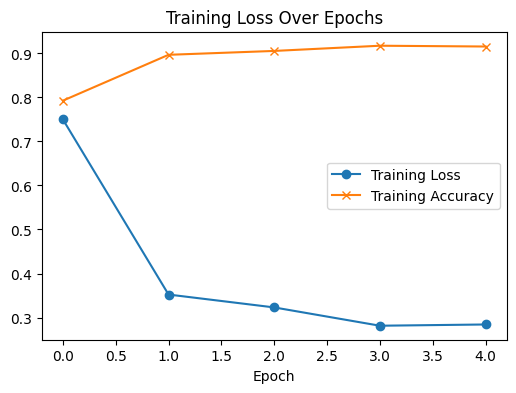

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], marker='o', label='Training Loss')
plt.plot(history.history['accuracy'], marker='x', label='Training Accuracy')
plt.xlabel('Epoch')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


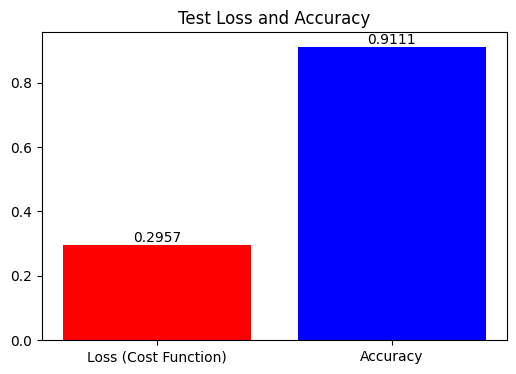

In [75]:
import matplotlib.pyplot as plt

# Prepare data for the diagram
metrics = ['Loss (Cost Function)', 'Accuracy']
values = [loss, accuracy]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['red', 'blue'])
plt.title('Test Loss and Accuracy')

# Annotate each bar with its value
for bar in bars:
    y_val = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, y_val, f'{y_val:.4f}', ha='center', va='bottom')
    
plt.show()

In [76]:
import os
os.makedirs("Models", exist_ok=True)

model.save("Models/saved_modell.keras")  # Speichert Architektur, Gewichte und Optimizer-Zustand
model.save_weights("Models/gewichte.weights.h5")  # Nur Gewichte speichern

from tensorflow.keras.models import load_model
geladenes_modell = load_model("Models/saved_modell.keras")
geladenes_modell.summary()  # Zeigt die Architektur an

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,520 (310.63 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,014 (207.09 KB)